A friend of mine claimed on Facebook:

> It was recently suggested that the NBA finals were rigged, perhaps to increase television ratings. So I did a simple analysis - suppose each game is a coin flip and each team has a 50% chance of winning each game. What is the expected distribution for the lengths the finals will go and how does it compare with reality?

> A simple calculation reveals P(4) = 8/64, P(5) = 16/64, P(6) = 20/64 and P(7) = 20/64.
> How does this compare with history? Out of 67 series n(4) = 8, n(5) = 16, n(6) = 24 and n(7) = 19 so pretty damn close to the shitty coin flip model.

> TL:DR - a simple statistical model suggests the nba finals are not rigged

3 things:

1. I know nothing about basketball.
2. I don't think that anybody's rigging games.
3. Let's examine this claim closer.

In [6]:
%matplotlib inline

# Standard imports.
import numpy as np
import pylab
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Resize plots.
pylab.rcParams['figure.figsize'] = 8, 4

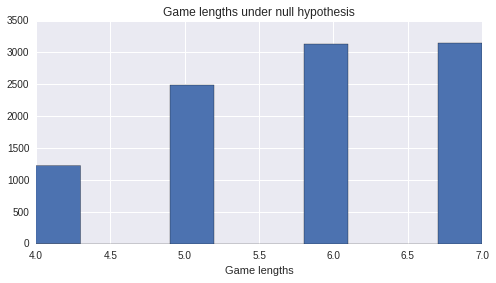

In [103]:
# Simulate 1000 series
game_lengths = []
for i in range(10000):
    wins_a = 0
    wins_b = 0
    for j in range(7):
        winning_team = np.random.rand() > .5
        if winning_team:
            wins_b += 1
        else:
            wins_a += 1
    
        if wins_a >= 4 or wins_b >= 4:
            break
    game_lengths.append(j + 1)
    continue
        
game_lengths = np.array(game_lengths)
plt.hist(game_lengths)
_ = plt.title('Game lengths under null hypothesis')
plt.xlabel('Game lengths')

In [104]:
print game_lengths.mean()

5.8202


Indeed, the coin flip model predicts that the distribution of game weights will have a lot of bulk around 6 and 7 games. What about historical games?

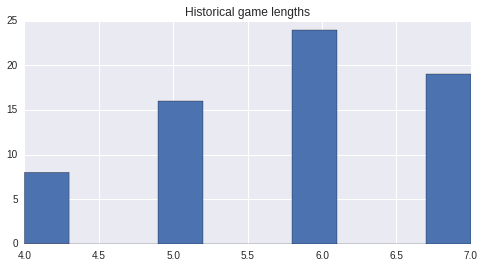

In [105]:
game_lengths_historical = np.hstack(([4] * 8, [5] * 16, [6] * 24, [7] * 19))
plt.hist(game_lengths_historical)
_ = plt.title('Historical game lengths')

In [106]:
print game_lengths_historical.mean()

5.80597014925


In fact, the historical game distribution indicates that the playoffs are slightly shorter than expected by chance. Does that mean that historical games haven't been rigged? Well, for one thing, you have to think about might cause game lengths to be shorter: blowouts. If one team is way better than the other, you would expect the series to be shorter than 7. In fact, the simulation with p = .5 represents the most extreme scenario, where every final is between two teams of exactly equal ability. 

That is almost certainly never the case; consider the Boston Celtics winning streak of the 60's - they must have been much stronger than any other team! We can estimate the (implied) probability of winning from sports betting data. Sports betters have every incentive to produce calibrated predictions, because it directly impacts their bottom line.

I looked at the moneylines from 2004 - 2015:

http://www.oddsshark.com/nba/nba-finals-historical-series-odds-list

In [22]:
dfs = pd.read_html('http://www.oddsshark.com/nba/nba-finals-historical-series-odds-list')
df = dfs[0]

df.columns = pd.Index(['year', 'west', 'west_moneyline', 'east', 'east_moneyline'])
df

,year,west,west_moneyline,east,east_moneyline
0,2015,Golden State,-190,Cleveland,170
1,2014,San Antonio,-125,Miami,105
2,2013,San Antonio,200,Miami,-240
3,2012,Oklahoma City,-160,Miami,140
4,2011,Dallas,160,Miami,-180
5,2010,LA Lakers,-180,Boston,160
6,2009,LA Lakers,-290,Orlando,240
7,2008,LA Lakers,-120,Boston,100
8,2007,San Antonio,-500,Cleveland,350
9,2006,Dallas,-145,Miami,125


I had a quick read through of:

http://www.bettingexpert.com/how-to/convert-odds

To transform these values into odds. Let's see what we get:

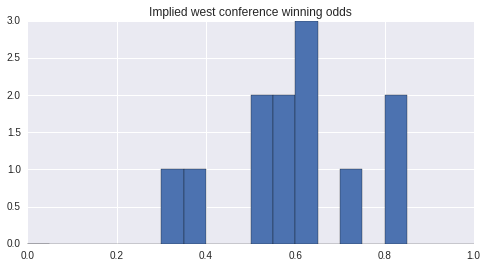

In [32]:
def moneyline_to_odds(val):
    if val < 0:
        return -val / (-val + 100.0)
    else:
        return 100 / (val + 100.0)

mean_odds = (df.west_moneyline.map(moneyline_to_odds) - 
             df.east_moneyline.map(moneyline_to_odds)
             + 1) / 2.0

plt.hist(mean_odds, np.arange(21) / 20.0)
plt.title('Implied west conference winning odds')

This is clearly not a delta distribution around 0.5 - there are favorites and underdogs. Let's fit this function to a beta distribution by eyeballing (the distribution has no particular signifiance here - it's just a convenience.

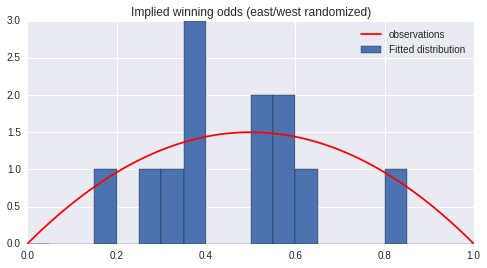

In [56]:
# Remove the West conference bias by flipping the sign of the odds at random.
alphas = np.zeros(25)
for n in range(25):
    flip_bits = np.random.rand(mean_odds.size) > .5
    mean_odds_shuffled = mean_odds * flip_bits + (1 - flip_bits) * (1 - mean_odds)
    alpha, beta, _, _ = scipy.stats.beta.fit(mean_odds_shuffled)
    # Symmetrize the result to have a mean of .5
    alphas[n] = ((alpha + beta)/2)

alpha = np.array(alphas).mean()
plt.hist(mean_odds_shuffled, np.arange(21) / 20.0)
x = np.arange(101) / 100.0
y = scipy.stats.beta.pdf(x, 1 + alpha, 1 + alpha) * 1.0
plt.plot(x, y, 'r-')
plt.legend(['observations', 'Fitted distribution'])
plt.title('Implied winning odds (east/west randomized)')

The fitted distribution is pretty broad -- but that's a distribution for the whole series of 6 games. If your win percentage for the whole series is 60%, what is it for a single game? Let's find out:

In [ ]:
game_win_percentages = np.arange(.5, 1, .01)
series_win_percentages = np.zeros_like(game_win_percentages)

Nsims = 4000
for k, frac in enumerate(game_win_percentages):
    wins = 0
    for i in range(Nsims):
        wins_a = 0
        wins_b = 0
        for j in range(7):
            winning_team = np.random.rand() > frac
            if winning_team:
                wins_b += 1
            else:
                wins_a += 1
                
            if wins_a == 4 or wins_b == 4:
                break
        wins += (wins_a == 4) * 1
    series_win_percentages[k] = wins / float(Nsims)
    

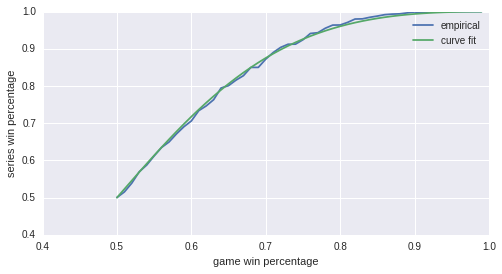

In [89]:
def logit(p):
    return np.log(p / (1 - p))

def logistic(x):
    """Returns the logistic of the numeric argument to the function.""" 
    return 1 / (1 + np.exp(-x))

plt.plot(game_win_percentages, series_win_percentages)

# Fit a logistic function by eye balling.
plt.plot(game_win_percentages, logistic(2.3*logit(game_win_percentages)))
plt.xlabel('game win percentage')
plt.ylabel('series win percentage')
plt.legend(['empirical', 'curve fit'])

We see that a series amplifies the signal as to which team is best or not - if a team has 70% odds of winning per game, that means they have a 90% chance of winning the series! Let's run a simulation to see the distribution of game lengths under this more subtle model.

In [93]:
def inverse_map(y):
    x = logistic(1 / 2.3 * logit(y))
    return x
assert np.allclose(inverse_map(logistic(2.3*logit(game_win_percentages))),
                   game_win_percentages)

(array([  32.,   92.,  100.,  141.,  141.,  127.,  133.,  126.,   70.,   38.]),
 array([ 0.00872055,  0.10706501,  0.20540948,  0.30375394,  0.4020984 ,
         0.50044286,  0.59878733,  0.69713179,  0.79547625,  0.89382072,
         0.99216518]),
 <a list of 10 Patch objects>)

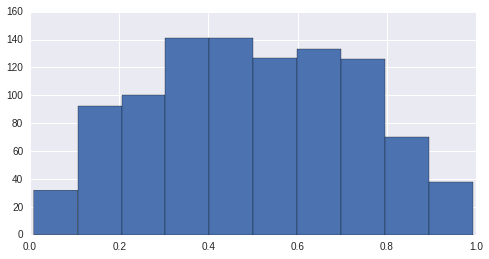

In [97]:
plt.hist(np.random.beta(alpha + 1, alpha + 1, 1000))

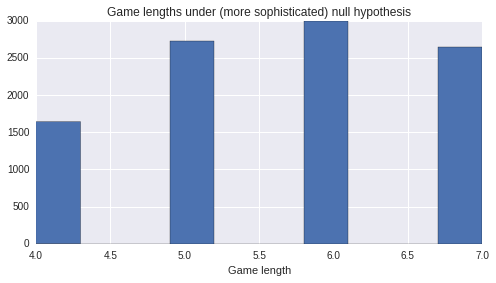

In [114]:
# Simulate 1000 series
game_lengths = []
for i in range(10000):
    # Pick a per series win percentage
    series_win_percentage = np.random.beta(alpha + 1, alpha + 1)
    # Transform to a per-game win percentage
    game_win_percentage = inverse_map(series_win_percentage)
    wins_a = 0
    wins_b = 0
    for j in range(7):
        winning_team = np.random.rand() > game_win_percentage
        if winning_team:
            wins_b += 1
        else:
            wins_a += 1
    
        if wins_a >= 4 or wins_b >= 4:
            break
    game_lengths.append(j + 1)
    continue
        
game_lengths = np.array(game_lengths)
plt.hist(game_lengths)
_ = plt.title('Game lengths under (more sophisticated) null hypothesis')
plt.xlabel('Game length')

In [100]:
game_lengths.mean()

5.6535000000000002

There is some movement towards shorter series in this simulation - series are shorter than observed in reality by about one game per 6 years. This is significant, however:

In [115]:
m = game_lengths_historical.mean()
ci = game_lengths_historical.std() / np.sqrt(float(game_lengths_historical.size))

print "Simulated series length is %.2f" % game_lengths.mean()
print "95%% CI for observed series length is [%.2f, %.2f]" % (m - 1.96*ci, m + 1.96*ci)

Simulated series length is 5.66
95% CI for observed series length is [5.57, 6.04]


That's not significant. Although 5.66 is on the low side of the distribution, decreasing the size of these error bars and declaring significance - and foul play! - would take decades! 

There's other processes that might contribute to increasing the series length - the most likely of which is the home effect. To see this, recall that for the first 4 games, two games are played at one team's stadium, and 2 others are played at the other teams stadium. If you have two teams which are exactly even, but which win 70% of home games, it's more likely that you'll end up 2-2 at the end of the 4 games than without a home team advantage:

(0, 4500)

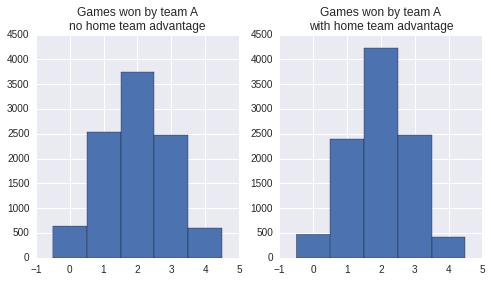

In [134]:
plt.subplot(121)
plt.hist(np.random.binomial(4, 0.5, size = (10000)), np.arange(6) - .5)
plt.title('Games won by team A\nno home team advantage')
plt.ylim([0, 4500])

plt.subplot(122)
plt.hist(np.random.binomial(2, 0.7, size = (10000)) + 
         np.random.binomial(2, 0.3, size = (10000)), np.arange(6) - .5)
plt.title('Games won by team A\nwith home team advantage')
plt.ylim([0, 4500])

[70% is much higher than the home team advantage we see these days](http://espn.go.com/nba/story/_/id/12241619/home-court-advantage-decline), but it will nevertheless make series longer. In any case, it would decades, with these methods, to measure any sort of foul play creating longer series; this is a job for investigative reporter, not a statistician!